In [ ]:
!which python
!python --version
# Install virtualenv if not already installed
!pip install virtualenv
!source /content/myenv/bin/activate

/usr/local/bin/python
Python 3.10.12
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 79.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.9/468.9 kB 27.1 MB/s eta 0:00:00
/bin/bash: line 1: /content/myenv/bin/activate: No such file or directory


In [ ]:
!pip install tensorflow==2.10.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.0/578.0 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 125.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 111.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 55.0 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  

In [ ]:
import os
import cv2
import numpy as np
import scipy.signal

!pip install segmentation-models==1.0.1
import segmentation_models as sm

from matplotlib import pyplot as plt
!pip install patchify
from patchify import patchify
from PIL import Image

from tensorflow.keras.metrics import MeanIoU

from sklearn.preprocessing import MinMaxScaler, StandardScaler

Segmentation Models: using `keras` framework.


In [ ]:
!pip install scipy --upgrade



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.1/41.1 MB 54.5 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xgboost 2.1.0 requires nvidia-nccl-cu12; platform_system == "Linux" and platform_machine != "aarch64", which is not installed.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.14.0 which is incompatible.


In [ ]:
# https://youtu.be/jvZm8REF2KY
"""
Standard Unet
Model not compiled here, instead will be done externally to make it
easy to test various loss functions and optimizers.
"""


from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)



################################################################
def multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    #model.summary()

    return model

# https://youtu.be/HrGn4uFrMOM

"""

Original code is from the following source. It comes with MIT License so please mention
the original reference when sharing.

The original code has been modified to fix a couple of bugs and chunks of code
unnecessary for smooth tiling are removed.

# MIT License
# Copyright (c) 2017 Vooban Inc.
# Coded by: Guillaume Chevalier
# Source to original code and license:
#     https://github.com/Vooban/Smoothly-Blend-Image-Patches
#     https://github.com/Vooban/Smoothly-Blend-Image-Patches/blob/master/LICENSE

"""
"""Perform smooth predictions on an image from tiled prediction patches."""


import numpy as np
import scipy.signal
from tqdm import tqdm

import gc


if __name__ == '__main__':
    import matplotlib.pyplot as plt
    PLOT_PROGRESS = True
    # See end of file for the rest of the __main__.
else:
    PLOT_PROGRESS = False


def _spline_window(window_size, power=2):
    """
    Squared spline (power=2) window function:
    https://www.wolframalpha.com/input/?i=y%3Dx**2,+y%3D-(x-2)**2+%2B2,+y%3D(x-4)**2,+from+y+%3D+0+to+2
    """
    intersection = int(window_size/4)
    #replace triag because of error
    def triangular_window(size):
        return 1 - abs((np.arange(size) - (size - 1) / 2) / ((size + 1) / 2))
    #wind_outer = (abs(2*(scipy.signal.triang(window_size))) ** power)/2
    wind_outer = (abs(2 * triangular_window(window_size)) ** power) / 2
    wind_outer[intersection:-intersection] = 0

    wind_inner = 1 - (abs(2*(scipy.signal.triang(window_size) - 1)) ** power)/2
    wind_inner[:intersection] = 0
    wind_inner[-intersection:] = 0

    wind = wind_inner + wind_outer
    wind = wind / np.average(wind)
    return wind


cached_2d_windows = dict()
def _window_2D(window_size, power=2):
    """
    Make a 1D window function, then infer and return a 2D window function.
    Done with an augmentation, and self multiplication with its transpose.
    Could be generalized to more dimensions.
    """
    # Memoization
    global cached_2d_windows
    key = "{}_{}".format(window_size, power)
    if key in cached_2d_windows:
        wind = cached_2d_windows[key]
    else:
        wind = _spline_window(window_size, power)
        wind = np.expand_dims(np.expand_dims(wind, 1), 1)      #SREENI: Changed from 3, 3, to 1, 1
        wind = wind * wind.transpose(1, 0, 2)
        if PLOT_PROGRESS:
            # For demo purpose, let's look once at the window:
            plt.imshow(wind[:, :, 0], cmap="viridis")
            plt.title("2D Windowing Function for a Smooth Blending of "
                      "Overlapping Patches")
            plt.show()
        cached_2d_windows[key] = wind
    return wind


def _pad_img(img, window_size, subdivisions):
    """
    Add borders to img for a "valid" border pattern according to "window_size" and
    "subdivisions".
    Image is an np array of shape (x, y, nb_channels).
    """
    aug = int(round(window_size * (1 - 1.0/subdivisions)))
    more_borders = ((aug, aug), (aug, aug), (0, 0))
    ret = np.pad(img, pad_width=more_borders, mode='reflect')
    # gc.collect()

    if PLOT_PROGRESS:
        # For demo purpose, let's look once at the window:
        plt.imshow(ret)
        plt.title("Padded Image for Using Tiled Prediction Patches\n"
                  "(notice the reflection effect on the padded borders)")
        plt.show()
    return ret


def _unpad_img(padded_img, window_size, subdivisions):
    """
    Undo what's done in the `_pad_img` function.
    Image is an np array of shape (x, y, nb_channels).
    """
    aug = int(round(window_size * (1 - 1.0/subdivisions)))
    ret = padded_img[
        aug:-aug,
        aug:-aug,
        :
    ]
    # gc.collect()
    return ret


def _rotate_mirror_do(im):
    """
    Duplicate an np array (image) of shape (x, y, nb_channels) 8 times, in order
    to have all the possible rotations and mirrors of that image that fits the
    possible 90 degrees rotations.
    It is the D_4 (D4) Dihedral group:
    https://en.wikipedia.org/wiki/Dihedral_group
    """
    mirrs = []
    mirrs.append(np.array(im))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=1))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=2))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=3))
    im = np.array(im)[:, ::-1]
    mirrs.append(np.array(im))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=1))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=2))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=3))
    return mirrs


def _rotate_mirror_undo(im_mirrs):
    """
    merges a list of 8 np arrays (images) of shape (x, y, nb_channels) generated
    from the `_rotate_mirror_do` function. Each images might have changed and
    merging them implies to rotated them back in order and average things out.
    It is the D_4 (D4) Dihedral group:
    https://en.wikipedia.org/wiki/Dihedral_group
    """
    origs = []
    origs.append(np.array(im_mirrs[0]))
    origs.append(np.rot90(np.array(im_mirrs[1]), axes=(0, 1), k=3))
    origs.append(np.rot90(np.array(im_mirrs[2]), axes=(0, 1), k=2))
    origs.append(np.rot90(np.array(im_mirrs[3]), axes=(0, 1), k=1))
    origs.append(np.array(im_mirrs[4])[:, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[5]), axes=(0, 1), k=3)[:, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[6]), axes=(0, 1), k=2)[:, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[7]), axes=(0, 1), k=1)[:, ::-1])
    return np.mean(origs, axis=0)


def _windowed_subdivs(padded_img, window_size, subdivisions, nb_classes, pred_func):
    """
    Create tiled overlapping patches.
    Returns:
        5D numpy array of shape = (
            nb_patches_along_X,
            nb_patches_along_Y,
            patches_resolution_along_X,
            patches_resolution_along_Y,
            nb_output_channels
        )
    Note:
        patches_resolution_along_X == patches_resolution_along_Y == window_size
    """
    WINDOW_SPLINE_2D = _window_2D(window_size=window_size, power=2)

    step = int(window_size/subdivisions)
    padx_len = padded_img.shape[0]
    pady_len = padded_img.shape[1]
    subdivs = []

    for i in range(0, padx_len-window_size+1, step):
        subdivs.append([])
        for j in range(0, pady_len-window_size+1, step):            #SREENI: Changed padx to pady (Bug in original code)
            patch = padded_img[i:i+window_size, j:j+window_size, :]
            subdivs[-1].append(patch)

    # Here, `gc.collect()` clears RAM between operations.
    # It should run faster if they are removed, if enough memory is available.
    gc.collect()
    subdivs = np.array(subdivs)
    gc.collect()
    a, b, c, d, e = subdivs.shape
    subdivs = subdivs.reshape(a * b, c, d, e)
    gc.collect()

    subdivs = pred_func(subdivs)
    gc.collect()
    subdivs = np.array([patch * WINDOW_SPLINE_2D for patch in subdivs])
    gc.collect()

    # Such 5D array:
    subdivs = subdivs.reshape(a, b, c, d, nb_classes)
    gc.collect()

    return subdivs


def _recreate_from_subdivs(subdivs, window_size, subdivisions, padded_out_shape):
    """
    Merge tiled overlapping patches smoothly.
    """
    step = int(window_size/subdivisions)
    padx_len = padded_out_shape[0]
    pady_len = padded_out_shape[1]

    y = np.zeros(padded_out_shape)

    a = 0
    for i in range(0, padx_len-window_size+1, step):
        b = 0
        for j in range(0, pady_len-window_size+1, step):                #SREENI: Changed padx to pady (Bug in original code)
            windowed_patch = subdivs[a, b]
            y[i:i+window_size, j:j+window_size] = y[i:i+window_size, j:j+window_size] + windowed_patch
            b += 1
        a += 1
    return y / (subdivisions ** 2)


def predict_img_with_smooth_windowing(input_img, window_size, subdivisions, nb_classes, pred_func):
    """
    Apply the `pred_func` function to square patches of the image, and overlap
    the predictions to merge them smoothly.
    See 6th, 7th and 8th idea here:
    http://blog.kaggle.com/2017/05/09/dstl-satellite-imagery-competition-3rd-place-winners-interview-vladimir-sergey/
    """
    pad = _pad_img(input_img, window_size, subdivisions)
    pads = _rotate_mirror_do(pad)

    # Note that the implementation could be more memory-efficient by merging
    # the behavior of `_windowed_subdivs` and `_recreate_from_subdivs` into
    # one loop doing in-place assignments to the new image matrix, rather than
    # using a temporary 5D array.

    # It would also be possible to allow different (and impure) window functions
    # that might not tile well. Adding their weighting to another matrix could
    # be done to later normalize the predictions correctly by dividing the whole
    # reconstructed thing by this matrix of weightings - to normalize things
    # back from an impure windowing function that would have badly weighted
    # windows.

    # For example, since the U-net of Kaggle's DSTL satellite imagery feature
    # prediction challenge's 3rd place winners use a different window size for
    # the input and output of the neural net's patches predictions, it would be
    # possible to fake a full-size window which would in fact just have a narrow
    # non-zero dommain. This may require to augment the `subdivisions` argument
    # to 4 rather than 2.

    res = []
    for pad in tqdm(pads):
        # For every rotation:
        sd = _windowed_subdivs(pad, window_size, subdivisions, nb_classes, pred_func)
        one_padded_result = _recreate_from_subdivs(
            sd, window_size, subdivisions,
            padded_out_shape=list(pad.shape[:-1])+[nb_classes])

        res.append(one_padded_result)

    # Merge after rotations:
    padded_results = _rotate_mirror_undo(res)

    prd = _unpad_img(padded_results, window_size, subdivisions)

    prd = prd[:input_img.shape[0], :input_img.shape[1], :]

    if PLOT_PROGRESS:
        # Convert predictions to RGB image before displaying
        prd = np.argmax(prd, axis=-1)  # Get class with highest probability
        # Assuming 'label_to_rgb' function is available to convert class indices to RGB
        prd_rgb = label_to_rgb(prd)
        plt.imshow(prd_rgb)
        plt.title("Smoothly Merged Patches that were Tiled Tighter")
        plt.show()
    return prd





In [ ]:
# https://youtu.be/jvZm8REF2KY
"""
Explanation of using RGB masks: https://youtu.be/sGAwx4GMe4E

https://www.kaggle.com/humansintheloop/semantic-segmentation-of-aerial-imagery

The dataset consists of aerial imagery of Dubai obtained by MBRSC satellites and annotated with pixel-wise semantic segmentation in 6 classes. The total volume of the dataset is 72 images grouped into 6 larger tiles. The classes are:

Building: #3C1098
Land (unpaved area): #8429F6
Road: #6EC1E4
Vegetation: #FEDD3A
Water: #E2A929
Unlabeled: #9B9B9B

Use patchify....
Tile 1: 797 x 644 --> 768 x 512 --> 6
Tile 2: 509 x 544 --> 512 x 256 --> 2
Tile 3: 682 x 658 --> 512 x 512  --> 4
Tile 4: 1099 x 846 --> 1024 x 768 --> 12
Tile 5: 1126 x 1058 --> 1024 x 1024 --> 16
Tile 6: 859 x 838 --> 768 x 768 --> 9
Tile 7: 1817 x 2061 --> 1792 x 2048 --> 56
Tile 8: 2149 x 1479 --> 1280 x 2048 --> 40
Total 9 images in each folder * (145 patches) = 1305
Total 1305 patches of size 256x256

"""


scaler = MinMaxScaler()
from google.colab import drive
drive.mount('/content/drive')

dataset_root_folder = '/content/drive/MyDrive/dataset/stormwater'

root_directory = '/content/drive/MyDrive/dataset/stormwater'

patch_size = 256


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:


#Read images from repsective 'images' subdirectory
#As all images are of ddifferent size we have 2 options, either resize or crop
#But, some images are too large and some small. Resizing will change the size of real objects.
#Therefore, we will crop them to a nearest size divisible by 256 and then
#divide all images into patches of 256x256x3.
image_dataset = []
for item in sorted(os.listdir(root_directory)):
  item_path = os.path.join(root_directory, item)
  if os.path.isdir(item_path):
      print("Folder:", item)
      images_path = os.path.join(item_path, "images")
      if os.path.exists(images_path):
            for image_name in sorted(os.listdir(images_path)):
               if image_name.endswith(".jpg"):   #Only read jpg images...
                image = cv2.imread(images_path+"/"+image_name, 1)  #Read each image as BGR
                SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                image = np.array(image)

                #Extract patches from each image
                print("Now patchifying image:", images_path+"/"+image_name)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap

                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):

                        single_patch_img = patches_img[i,j,:,:]

                        #Use minmaxscaler instead of just dividing by 255.
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)

                        #single_patch_img = (single_patch_img.astype('float32')) / 255.
                        single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.
                        image_dataset.append(single_patch_img)




 #Now do the same as above for masks
 #For this specific dataset we could have added masks to the above code as masks have extension png
mask_dataset = []
for item in sorted(os.listdir(root_directory)):
  item_path = os.path.join(root_directory, item)
  if os.path.isdir(item_path):
      print("Folder:", item)
      images_path = os.path.join(item_path, "masks")
      if os.path.exists(images_path):
            for mask_name in sorted(os.listdir(images_path)):
               if mask_name.endswith(".png"):   #Only read jpg images...
                mask = cv2.imread(images_path+"/"+mask_name, 1)  #Read each image as Grey (or color but remember to map each color to an integer)
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #mask = mask.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                mask = np.array(mask)

                #Extract patches from each image
                print("Now patchifying mask:", images_path+"/"+mask_name)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap

                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):

                        single_patch_mask = patches_mask[i,j,:,:]
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. #No need to scale masks, but you can do it if you want
                        single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.
                        mask_dataset.append(single_patch_mask)

image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)


Folder: Tile1
Now patchifying image: /content/drive/MyDrive/dataset/stormwater/Tile1/images/image2.jpg
Now patchifying image: /content/drive/MyDrive/dataset/stormwater/Tile1/images/image3.jpg
Now patchifying image: /content/drive/MyDrive/dataset/stormwater/Tile1/images/image4.jpg
Now patchifying image: /content/drive/MyDrive/dataset/stormwater/Tile1/images/image5.jpg
Now patchifying image: /content/drive/MyDrive/dataset/stormwater/Tile1/images/image6.jpg
Now patchifying image: /content/drive/MyDrive/dataset/stormwater/Tile1/images/image7.jpg
Now patchifying image: /content/drive/MyDrive/dataset/stormwater/Tile1/images/image8.jpg
Now patchifying image: /content/drive/MyDrive/dataset/stormwater/Tile1/images/image9.jpg
Folder: original
Folder: recolor
Folder: stormwater
Folder: Tile1
Now patchifying mask: /content/drive/MyDrive/dataset/stormwater/Tile1/masks/image2.png
Now patchifying mask: /content/drive/MyDrive/dataset/stormwater/Tile1/masks/image3.png
Now patchifying mask: /content/dri

In [ ]:
print (image_dataset.shape)
print (mask_dataset.shape)
print(image.shape)

(48, 256, 256, 3)
(48, 256, 256, 3)
(512, 768, 3)


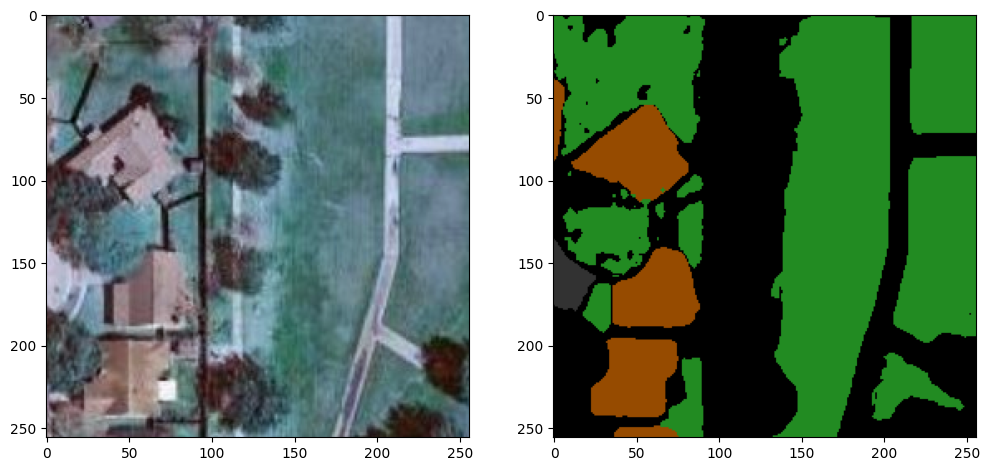

In [ ]:

#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()



Unique labels in label dataset are: [ 0  1  2  4  5  6  8  9 10 11 12]


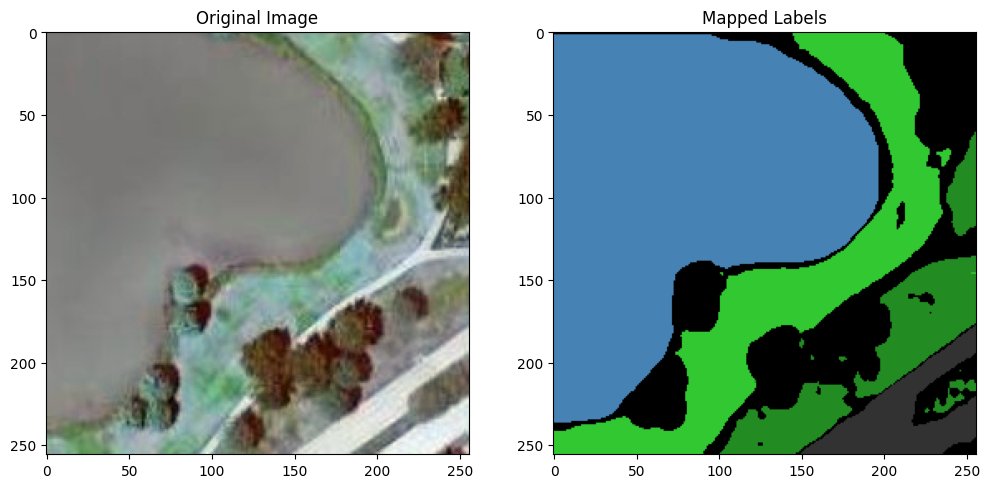

In [ ]:
#NEW ONE
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Define RGB colors
color_tuples = {
    "city_pavement": (100, 100, 100),
    "commercial_rooftop": (200, 200, 200),
    "golf_course": (50, 200, 50),
    "grassland": (124, 252, 0),
    "lake": (70, 130, 180),
    "parking_lot": (169, 169, 169),
    "pavement": (150, 150, 150),
    "public_landscape": (60, 179, 113),
    "residential_rooftop": (150, 75, 0),
    "roads": (50, 50, 50),
    "stream": (0, 191, 255),
    "yard": (34, 139, 34),
    "Unlabel": (0, 0, 0)

}

# Convert to arrays for colormap
colors_array = np.array(list(color_tuples.values()))

# Create a colormap
cmap = mcolors.ListedColormap(colors_array / 255.0)  # Normalize to [0, 1] for matplotlib
norm = mcolors.BoundaryNorm(boundaries=np.arange(len(colors_array) + 1) - 0.5, ncolors=len(colors_array))

# Function to map RGB to the corresponding class name
def rgb_to_class_name(rgb):
    for name, color in color_tuples.items():
        if np.all(rgb == color):
            return name
    return "Unknown"

# Function to convert RGB masks to labels
def rgb_to_labels(mask):
    height, width, _ = mask.shape
    labels = np.zeros((height, width), dtype=np.uint8)
    for idx, (name, color) in enumerate(color_tuples.items()):
        labels[np.all(mask == color, axis=-1)] = idx
    return labels

# Apply function to dataset
labels = np.array([rgb_to_labels(mask) for mask in mask_dataset])

# Check unique labels
print("Unique labels in label dataset are:", np.unique(labels))

# Visualize a few images
image_number = random.randint(0, len(image_dataset) - 1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.title("Original Image")
plt.subplot(122)
plt.imshow(mask_dataset[image_number], cmap=cmap, norm=norm)
plt.title("Mapped Labels")
plt.show()

# Categorize labels
n_classes = len(color_tuples)
labels_cat = to_categorical(labels, num_classes=n_classes)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size=0.20, random_state=42)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

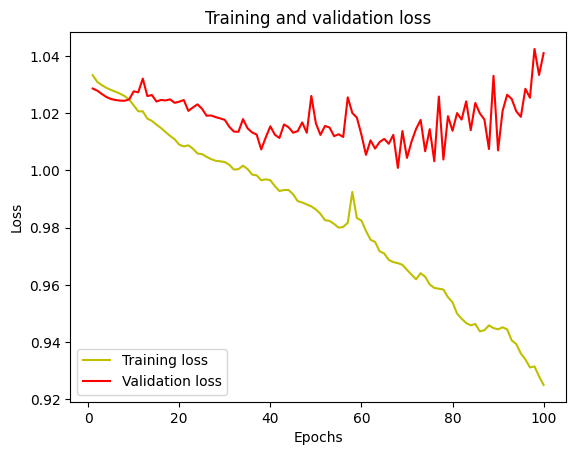

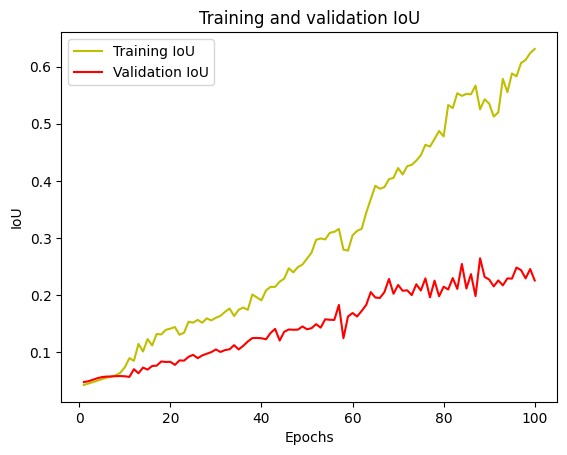

In [ ]:


#######################################
#Parameters for model
# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss
# from sklearn.utils.class_weight import compute_class_weight

# weights = compute_class_weight('balanced', np.unique(np.ravel(labels,order='C')),
#                               np.ravel(labels,order='C'))
# print(weights)

weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666  ]
dice_loss = sm.losses.DiceLoss(class_weights=weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)  #


IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

#from simple_multi_unet_model import multi_unet_model, jacard_coef

metrics=['accuracy', jacard_coef]

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
model.summary()


history1 = model.fit(X_train, y_train,
                    batch_size = 16,
                    verbose=1,
                    epochs=100,
                    validation_data=(X_test, y_test),
                    shuffle=False)

#Minmaxscaler
#With weights...[0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]   in Dice loss
#With focal loss only, after 100 epochs val jacard is: 0.62  (Mean IoU: 0.6)
#With dice loss only, after 100 epochs val jacard is: 0.74 (Reached 0.7 in 40 epochs)
#With dice + 5 focal, after 100 epochs val jacard is: 0.711 (Mean IoU: 0.611)
##With dice + 1 focal, after 100 epochs val jacard is: 0.75 (Mean IoU: 0.62)
#Using categorical crossentropy as loss: 0.71

##With calculated weights in Dice loss.
#With dice loss only, after 100 epochs val jacard is: 0.672 (0.52 iou)


##Standardscaler
#Using categorical crossentropy as loss: 0.677

model.save('/content/drive/MyDrive/dataset/stormwater/satellite_standard_unet_100epochs.hdf5')

###########################################################
#plot the training and validation accuracy and loss at each epoch
history = history1
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

1/1 [==============================] - 1s 548ms/step
(10, 256, 256, 13)
Mean IoU = 0.18639255
1/1 [==============================] - 0s 57ms/step


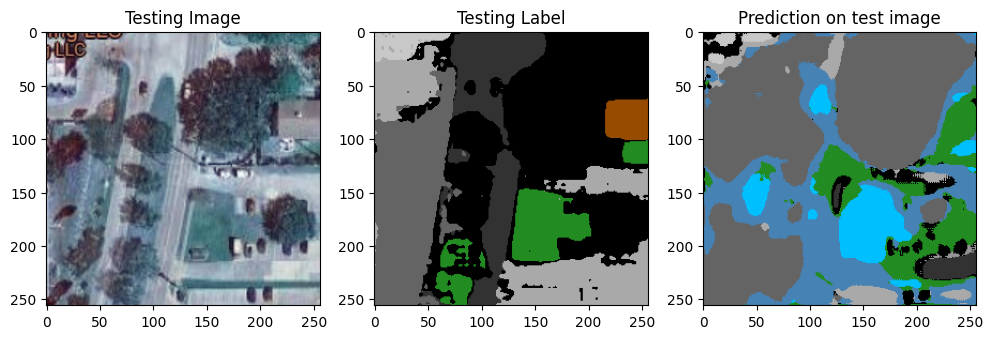

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random
from keras.models import load_model
from keras.utils import custom_object_scope
from keras.metrics import MeanIoU

# Define RGB arrays with specific colors
color_tuples = {
    "city_pavement": (100, 100, 100),
    "commercial_rooftop": (200, 200, 200),
    "golf_course": (50, 200, 50),
    "grassland": (124, 252, 0),
    "lake": (70, 130, 180),
    "parking_lot": (169, 169, 169),
    "pavement": (150, 150, 150),
    "public_landscape": (60, 179, 113),
    "residential_rooftop": (150, 75, 0),
    "roads": (50, 50, 50),
    "stream": (0, 191, 255),
    "yard": (34, 139, 34),
    "Unlabel": (0, 0, 0)
}
# Convert to arrays for colormap
colors_array = np.array(list(color_tuples.values()))

# Create a colormap
cmap = mcolors.ListedColormap(colors_array / 255.0)  # Normalize to [0, 1] for matplotlib
norm = mcolors.BoundaryNorm(boundaries=np.arange(len(colors_array) + 1) - 0.5, ncolors=len(colors_array))

# Function to convert class indices to RGB images
def label_to_rgb(label):
    rgb_image = np.zeros((label.shape[0], label.shape[1], 3), dtype=np.uint8)
    for idx, color in enumerate(colors_array):
        rgb_image[label == idx] = color
    return rgb_image

def dice_loss_plus_1focal_loss(y_true, y_pred):
    dice_loss = sm.losses.DiceLoss(class_weights=weights)  # Make sure 'weights' is defined
    focal_loss = sm.losses.CategoricalFocalLoss()
    return dice_loss + (1 * focal_loss)

with custom_object_scope({'dice_loss_plus_1focal_loss': dice_loss_plus_1focal_loss, 'jacard_coef': jacard_coef}):
    model = load_model("/content/drive/MyDrive/dataset/stormwater/satellite_standard_unet_100epochs.hdf5")

# IOU calculation
y_pred = model.predict(X_test)
print (y_pred.shape)
y_pred_argmax = np.argmax(y_pred, axis=3)
y_test_argmax = np.argmax(y_test, axis=3)

# Using built-in keras function for IoU
n_classes = 13
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

#######################################################################
# Predict on a few images
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth = y_test_argmax[test_img_number]
test_img_input = np.expand_dims(test_img, 0)
prediction = model.predict(test_img_input)
predicted_img = np.argmax(prediction, axis=3)[0, :, :]

# Convert label indices to RGB images
ground_truth_rgb = label_to_rgb(ground_truth)
predicted_img_rgb = label_to_rgb(predicted_img)

# Visualize the results
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth_rgb)  # Display RGB ground truth
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img_rgb)  # Display RGB prediction
plt.show()


In [ ]:
from PIL import Image
import numpy as np
from tabulate import tabulate

# Dictionary of land features with their corresponding RGB values and curve numbers
color_tuples = {
    "golf_course": {"rgb": (50, 200, 50), "curve_number": 55},
    "pavement_residential": {"rgb": (150, 150, 150), "curve_number": 98},
    "pavement_city": {"rgb": (90, 90, 90), "curve_number": 98},
    "land_grassland": {"rgb": (124, 252, 0), "curve_number": 61},
    "land_urban": {"rgb": (100, 100, 100), "curve_number": 79},
    "stream": {"rgb": (0, 191, 255), "curve_number": 100},
    "lake": {"rgb": (70, 130, 180), "curve_number": 100},
    "yard": {"rgb": (34, 139, 34), "curve_number": 74},
    "parking_lot": {"rgb": (169, 169, 169), "curve_number": 98},
    "commercial_rooftop": {"rgb": (200, 200, 200), "curve_number": 98},
    "residential_rooftop": {"rgb": (150, 75, 0), "curve_number": 98},
    "roads": {"rgb": (50, 50, 50), "curve_number": 98},
    "Unlabel": {"rgb": (0, 0, 0), "curve_number": None}
}

def count_pixels_and_percentages(image_path, color_tuples):
    # Open the image

    np_image = np.array(predicted_img_rgb)

    # Get the total number of pixels in the image
    total_pixels = np_image.shape[0] * np_image.shape[1]

    # Dictionary to store counts of pixels and percentages for each land feature
    pixel_info = {key: {'percentage': 0.0, 'curve_number': color_tuples[key]['curve_number']} for key in color_tuples}

    # Count pixels
    for feature, info in color_tuples.items():
        rgb = info['rgb']
        # Create a boolean mask where the pixels match the RGB value
        mask = np.all(np_image == rgb, axis=-1)
        # Count the number of True values in the mask
        pixel_count = np.sum(mask)
        # Calculate the percentage of pixels
        pixel_percentage = (pixel_count / total_pixels) * 100
        # Store the rounded percentage in the dictionary
        pixel_info[feature]['percentage'] = round(pixel_percentage)

    return pixel_info

def calculate_weighted_average(pixel_info):
    weighted_sum = 0.0
    total_percentage = 0.0

    for feature, info in pixel_info.items():
        percentage = info['percentage']
        curve_number = info['curve_number']
        if curve_number is not None:
            weighted_sum += percentage * curve_number
            total_percentage += percentage

    weighted_average = weighted_sum / total_percentage if total_percentage > 0 else None
    return weighted_average

# Example usage
image_path = "path_to_your_image.jpg"  # Replace with the path to your image file
pixel_info = count_pixels_and_percentages(image_path, color_tuples)

# Calculate weighted average of curve number
weighted_average_curve_number = calculate_weighted_average(pixel_info)

# Prepare data for tabulate
table_data = [(feature, info['percentage'], info['curve_number']) for feature, info in pixel_info.items()]
table_headers = ["Land Feature", "Percentage (%)", "Curve Number"]

# Print the table
print(tabulate(table_data, headers=table_headers, tablefmt="grid"))

# Print the weighted average curve number
print(f"\nWeighted Average Curve Number: {weighted_average_curve_number:.2f}")


+----------------------+------------------+----------------+
| Land Feature         |   Percentage (%) |   Curve Number |
+======================+==================+================+
| golf_course          |                0 |             55 |
+----------------------+------------------+----------------+
| pavement_residential |                0 |             98 |
+----------------------+------------------+----------------+
| pavement_city        |                0 |             98 |
+----------------------+------------------+----------------+
| land_grassland       |                0 |             61 |
+----------------------+------------------+----------------+
| land_urban           |                0 |             79 |
+----------------------+------------------+----------------+
| stream               |                0 |            100 |
+----------------------+------------------+----------------+
| lake                 |                0 |            100 |
+----------------------+

In [ ]:
# https://youtu.be/HrGn4uFrMOM

"""

Original code is from the following source. It comes with MIT License so please mention
the original reference when sharing.

The original code has been modified to fix a couple of bugs and chunks of code
unnecessary for smooth tiling are removed.

# MIT License
# Copyright (c) 2017 Vooban Inc.
# Coded by: Guillaume Chevalier
# Source to original code and license:
#     https://github.com/Vooban/Smoothly-Blend-Image-Patches
#     https://github.com/Vooban/Smoothly-Blend-Image-Patches/blob/master/LICENSE

"""
"""Perform smooth predictions on an image from tiled prediction patches."""


import numpy as np
import scipy.signal
from tqdm import tqdm

import gc


if __name__ == '__main__':
    import matplotlib.pyplot as plt
    PLOT_PROGRESS = True
    # See end of file for the rest of the __main__.
else:
    PLOT_PROGRESS = False


def _spline_window(window_size, power=2):
    """
    Squared spline (power=2) window function:
    https://www.wolframalpha.com/input/?i=y%3Dx**2,+y%3D-(x-2)**2+%2B2,+y%3D(x-4)**2,+from+y+%3D+0+to+2
    """
    intersection = int(window_size/4)
    wind_outer = (abs(2*(scipy.signal.triang(window_size))) ** power)/2
    wind_outer[intersection:-intersection] = 0

    wind_inner = 1 - (abs(2*(scipy.signal.triang(window_size) - 1)) ** power)/2
    wind_inner[:intersection] = 0
    wind_inner[-intersection:] = 0

    wind = wind_inner + wind_outer
    wind = wind / np.average(wind)
    return wind


cached_2d_windows = dict()
def _window_2D(window_size, power=2):
    """
    Make a 1D window function, then infer and return a 2D window function.
    Done with an augmentation, and self multiplication with its transpose.
    Could be generalized to more dimensions.
    """
    # Memoization
    global cached_2d_windows
    key = "{}_{}".format(window_size, power)
    if key in cached_2d_windows:
        wind = cached_2d_windows[key]
    else:
        wind = _spline_window(window_size, power)
        wind = np.expand_dims(np.expand_dims(wind, 1), 1)      #SREENI: Changed from 3, 3, to 1, 1
        wind = wind * wind.transpose(1, 0, 2)
        if PLOT_PROGRESS:
            # For demo purpose, let's look once at the window:
            plt.imshow(wind[:, :, 0], cmap="viridis")
            plt.title("2D Windowing Function for a Smooth Blending of "
                      "Overlapping Patches")
            plt.show()
        cached_2d_windows[key] = wind
    return wind


def _pad_img(img, window_size, subdivisions):
    """
    Add borders to img for a "valid" border pattern according to "window_size" and
    "subdivisions".
    Image is an np array of shape (x, y, nb_channels).
    """
    aug = int(round(window_size * (1 - 1.0/subdivisions)))
    more_borders = ((aug, aug), (aug, aug), (0, 0))
    ret = np.pad(img, pad_width=more_borders, mode='reflect')
    # gc.collect()

    if PLOT_PROGRESS:
        # For demo purpose, let's look once at the window:
        plt.imshow(ret)
        plt.title("Padded Image for Using Tiled Prediction Patches\n"
                  "(notice the reflection effect on the padded borders)")
        plt.show()
    return ret


def _unpad_img(padded_img, window_size, subdivisions):
    """
    Undo what's done in the `_pad_img` function.
    Image is an np array of shape (x, y, nb_channels).
    """
    aug = int(round(window_size * (1 - 1.0/subdivisions)))
    ret = padded_img[
        aug:-aug,
        aug:-aug,
        :
    ]
    # gc.collect()
    return ret


def _rotate_mirror_do(im):
    """
    Duplicate an np array (image) of shape (x, y, nb_channels) 8 times, in order
    to have all the possible rotations and mirrors of that image that fits the
    possible 90 degrees rotations.
    It is the D_4 (D4) Dihedral group:
    https://en.wikipedia.org/wiki/Dihedral_group
    """
    mirrs = []
    mirrs.append(np.array(im))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=1))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=2))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=3))
    im = np.array(im)[:, ::-1]
    mirrs.append(np.array(im))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=1))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=2))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=3))
    return mirrs


def _rotate_mirror_undo(im_mirrs):
    """
    merges a list of 8 np arrays (images) of shape (x, y, nb_channels) generated
    from the `_rotate_mirror_do` function. Each images might have changed and
    merging them implies to rotated them back in order and average things out.
    It is the D_4 (D4) Dihedral group:
    https://en.wikipedia.org/wiki/Dihedral_group
    """
    origs = []
    origs.append(np.array(im_mirrs[0]))
    origs.append(np.rot90(np.array(im_mirrs[1]), axes=(0, 1), k=3))
    origs.append(np.rot90(np.array(im_mirrs[2]), axes=(0, 1), k=2))
    origs.append(np.rot90(np.array(im_mirrs[3]), axes=(0, 1), k=1))
    origs.append(np.array(im_mirrs[4])[:, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[5]), axes=(0, 1), k=3)[:, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[6]), axes=(0, 1), k=2)[:, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[7]), axes=(0, 1), k=1)[:, ::-1])
    return np.mean(origs, axis=0)


def _windowed_subdivs(padded_img, window_size, subdivisions, nb_classes, pred_func):
    """
    Create tiled overlapping patches.
    Returns:
        5D numpy array of shape = (
            nb_patches_along_X,
            nb_patches_along_Y,
            patches_resolution_along_X,
            patches_resolution_along_Y,
            nb_output_channels
        )
    Note:
        patches_resolution_along_X == patches_resolution_along_Y == window_size
    """
    WINDOW_SPLINE_2D = _window_2D(window_size=window_size, power=2)

    step = int(window_size/subdivisions)
    padx_len = padded_img.shape[0]
    pady_len = padded_img.shape[1]
    subdivs = []

    for i in range(0, padx_len-window_size+1, step):
        subdivs.append([])
        for j in range(0, pady_len-window_size+1, step):            #SREENI: Changed padx to pady (Bug in original code)
            patch = padded_img[i:i+window_size, j:j+window_size, :]
            subdivs[-1].append(patch)

    # Here, `gc.collect()` clears RAM between operations.
    # It should run faster if they are removed, if enough memory is available.
    gc.collect()
    subdivs = np.array(subdivs)
    gc.collect()
    a, b, c, d, e = subdivs.shape
    subdivs = subdivs.reshape(a * b, c, d, e)
    gc.collect()

    subdivs = pred_func(subdivs)
    gc.collect()
    subdivs = np.array([patch * WINDOW_SPLINE_2D for patch in subdivs])
    gc.collect()

    # Such 5D array:
    subdivs = subdivs.reshape(a, b, c, d, nb_classes)
    gc.collect()

    return subdivs


def _recreate_from_subdivs(subdivs, window_size, subdivisions, padded_out_shape):
    """
    Merge tiled overlapping patches smoothly.
    """
    step = int(window_size/subdivisions)
    padx_len = padded_out_shape[0]
    pady_len = padded_out_shape[1]

    y = np.zeros(padded_out_shape)

    a = 0
    for i in range(0, padx_len-window_size+1, step):
        b = 0
        for j in range(0, pady_len-window_size+1, step):                #SREENI: Changed padx to pady (Bug in original code)
            windowed_patch = subdivs[a, b]
            y[i:i+window_size, j:j+window_size] = y[i:i+window_size, j:j+window_size] + windowed_patch
            b += 1
        a += 1
    return y / (subdivisions ** 2)


def predict_img_with_smooth_windowing(input_img, window_size, subdivisions, nb_classes, pred_func):
    """
    Apply the `pred_func` function to square patches of the image, and overlap
    the predictions to merge them smoothly.
    See 6th, 7th and 8th idea here:
    http://blog.kaggle.com/2017/05/09/dstl-satellite-imagery-competition-3rd-place-winners-interview-vladimir-sergey/
    """
    pad = _pad_img(input_img, window_size, subdivisions)
    pads = _rotate_mirror_do(pad)

    # Note that the implementation could be more memory-efficient by merging
    # the behavior of `_windowed_subdivs` and `_recreate_from_subdivs` into
    # one loop doing in-place assignments to the new image matrix, rather than
    # using a temporary 5D array.

    # It would also be possible to allow different (and impure) window functions
    # that might not tile well. Adding their weighting to another matrix could
    # be done to later normalize the predictions correctly by dividing the whole
    # reconstructed thing by this matrix of weightings - to normalize things
    # back from an impure windowing function that would have badly weighted
    # windows.

    # For example, since the U-net of Kaggle's DSTL satellite imagery feature
    # prediction challenge's 3rd place winners use a different window size for
    # the input and output of the neural net's patches predictions, it would be
    # possible to fake a full-size window which would in fact just have a narrow
    # non-zero dommain. This may require to augment the `subdivisions` argument
    # to 4 rather than 2.

    res = []
    for pad in tqdm(pads):
        # For every rotation:
        sd = _windowed_subdivs(pad, window_size, subdivisions, nb_classes, pred_func)
        one_padded_result = _recreate_from_subdivs(
            sd, window_size, subdivisions,
            padded_out_shape=list(pad.shape[:-1])+[nb_classes])

        res.append(one_padded_result)

    # Merge after rotations:
    padded_results = _rotate_mirror_undo(res)

    prd = _unpad_img(padded_results, window_size, subdivisions)

    prd = prd[:input_img.shape[0], :input_img.shape[1], :]

    if PLOT_PROGRESS:
        # Convert predictions to RGB image before displaying
        prd = np.argmax(prd, axis=-1)  # Get class with highest probability
        # Assuming 'label_to_rgb' function is available to convert class indices to RGB
        prd_rgb = label_to_rgb(prd)
        plt.imshow(prd_rgb)
        plt.title("Smoothly Merged Patches that were Tiled Tighter")
        plt.show()
    return prd



1/1 [==============================] - 0s 57ms/step


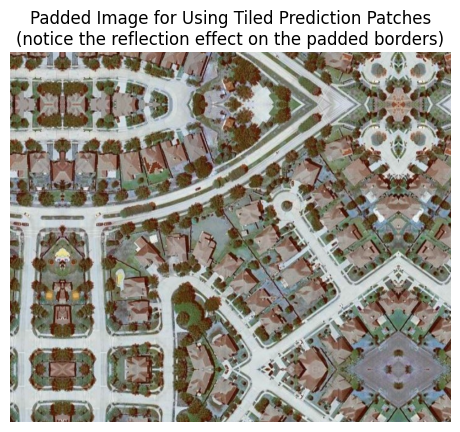

  0%|          | 0/8 [00:00<?, ?it/s]


AttributeError: module 'scipy.signal' has no attribute 'triang'

In [ ]:



# https://youtu.be/HrGn4uFrMOM
"""
Prediction using smooth tiling as descibed here...

https://github.com/Vooban/Smoothly-Blend-Image-Patches


"""

import cv2
import numpy as np

from matplotlib import pyplot as plt
from patchify import patchify, unpatchify
from PIL import Image
import segmentation_models as sm

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

import scipy.signal

img = cv2.imread("/content/drive/MyDrive/dataset/stormwater/Tile1/images/image5.jpg", 1)
original_mask = cv2.imread("/content/drive/MyDrive/dataset/stormwater/Tile1/masks/image5.png", 1)
original_mask = cv2.cvtColor(original_mask,cv2.COLOR_BGR2RGB)


# weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
# dice_loss = sm.losses.DiceLoss(class_weights=weights)
# focal_loss = sm.losses.CategoricalFocalLoss()
# total_loss = dice_loss + (2 * focal_loss)  #

from keras.models import load_model

model = load_model("/content/drive/MyDrive/dataset/stormwater/satellite_standard_unet_100epochs.hdf5", compile=False)

# size of patches
patch_size = 256

# Number of classes
n_classes = 13


#################################################################################
#Predict patch by patch with no smooth blending
###########################################

SIZE_X = (img.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
SIZE_Y = (img.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
large_img = Image.fromarray(img)
large_img = large_img.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
#image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
large_img = np.array(large_img)


patches_img = patchify(large_img, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
patches_img = patches_img[:,:,0,:,:,:]

patched_prediction = []
for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):

        single_patch_img = patches_img[i,j,:,:,:]

        #Use minmaxscaler instead of just dividing by 255.
        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
        single_patch_img = np.expand_dims(single_patch_img, axis=0)
        pred = model.predict(single_patch_img)
        pred = np.argmax(pred, axis=3)
        pred = pred[0, :,:]

        patched_prediction.append(pred)

patched_prediction = np.array(patched_prediction)
patched_prediction = np.reshape(patched_prediction, [patches_img.shape[0], patches_img.shape[1],
                                            patches_img.shape[2], patches_img.shape[3]])

unpatched_prediction = unpatchify(patched_prediction, (large_img.shape[0], large_img.shape[1]))

plt.imshow(unpatched_prediction)
plt.axis('off')
###################################################################################
#Predict using smooth blending

input_img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)

# Use the algorithm. The `pred_func` is passed and will process all the image 8-fold by tiling small patches with overlap, called once with all those image as a batch outer dimension.
# Note that model.predict(...) accepts a 4D tensor of shape (batch, x, y, nb_channels), such as a Keras model.
predictions_smooth = predict_img_with_smooth_windowing(
    input_img,
    window_size=patch_size,
    subdivisions=2,  # Minimal amount of overlap for windowing. Must be an even number.
    nb_classes=n_classes,
    pred_func=(
        lambda img_batch_subdiv: model.predict((img_batch_subdiv))
    )
)


final_prediction = np.argmax(predictions_smooth, axis=1)

###################
#Convert labeled images back to original RGB colored masks.

def label_to_rgb(predicted_image):

    color_tuple = (50, 200, 50)
    golf_course = np.array(color_tuple)

    color_tuple2 = (150, 150, 150)
    pavement_residential = np.array(color_tuple2)

    color_tuple3 = (90, 90, 90)
    pavement_city = np.array(color_tuple3)

    color_tuple4 = (124, 252, 0) #Done
    land_grassland = np.array(color_tuple4)

    color_tuple5 = (100, 100, 100) #Done
    land_urban = np.array(color_tuple5)

    color_tuple6 = (0, 191, 255)
    stream = np.array(color_tuple6)

    color_tuple7 = (70, 130, 180)
    lake = np.array(color_tuple7)
    color_tuple8 = (34, 139, 34)
    yard = np.array(color_tuple8)

    color_tuple9 = (169, 169, 169)
    parking_lot = np.array(color_tuple9)

    color_tuple10 = (200, 200, 200)
    commercial_rooftop = np.array(color_tuple10)

    color_tuple11 = (150, 75, 0)
    residential_rooftop = np.array(color_tuple11)

    color_tuple12 = (50, 50, 50)
    roads = np.array(color_tuple12)

    color_tuple13 = (0, 0, 0)
    Unlabeled = np.array(color_tuple13)


    segmented_img = np.empty((predicted_image.shape[0], predicted_image.shape[1], 3))

    segmented_img[(predicted_image == 0)] = golf_course
    segmented_img[(predicted_image == 1)] = pavement_residential
    segmented_img[(predicted_image == 2)] = pavement_city
    segmented_img[(predicted_image == 3)] = land_grassland
    segmented_img[(predicted_image == 4)] = land_urban
    segmented_img[(predicted_image == 5)] = stream
    segmented_img[(predicted_image == 6)] = lake
    segmented_img[(predicted_image == 7)] = yard
    segmented_img[(predicted_image == 8)] = parking_lot
    segmented_img[(predicted_image == 9)] = commercial_rooftop
    segmented_img[(predicted_image == 10)] = residential_rooftop
    segmented_img[(predicted_image == 11)] = roads
    segmented_img[(predicted_image == 12)] = Unlabeled


    segmented_img = segmented_img.astype(np.uint8)
    return(segmented_img)



########################
#Plot and save results
prediction_with_smooth_blending=label_to_rgb(final_prediction)
prediction_without_smooth_blending=label_to_rgb(unpatched_prediction)


plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.title('Testing Image')
plt.imshow(img)
plt.subplot(222)
plt.title('Testing Label')
plt.imshow(original_mask)
plt.subplot(223)
plt.title('Prediction without smooth blending')
plt.imshow(prediction_without_smooth_blending)
plt.subplot(224)
plt.title('Prediction with smooth blending')
plt.imshow(prediction_with_smooth_blending)
plt.show()

#############################

In [ ]:
scipy.__version__


NameError: name 'scipy' is not defined